# Player Development & Aging Curve Analysis

This notebook implements the workflow described in `player_development_analysis_aging_curve.md`, covering:

1. Building aging curves for performance and valuation by position and age.
2. Computing per-player development metrics (expected vs actual value/performance).
3. Generating an `aging_score` and `development_tier` that can be merged into the recommendation pipeline.
4. Showing how to refresh the analysis when new raw data arrives.

## 1. Imports & Global Config
All imports remain in a single cell so the notebook is easy to rerun when dependencies change.

In [2]:

# Core analysis stack
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Configure aesthetics for visual checks
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({"figure.figsize": (12, 6)})

# Constants used across functions
DATA_DIR = Path("../data")
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(exist_ok=True)
MILLION = 1_000_000


## 2. Helper Functions
Functions encapsulate key steps (loading data, computing age, smoothing) so the same logic can be reused when new data arrives.

In [3]:

def load_raw_data(data_dir: Path) -> dict:
    """Load all CSVs required for the development analysis."""
    files = {
        "players": "players.csv",
        "player_valuations": "player_valuations.csv",
        "appearances": "appearances.csv",
        "competitions": "competitions.csv",
        "games": "games.csv",
    }
    dfs = {}
    for key, fname in files.items():
        path = data_dir / fname
        dfs[key] = pd.read_csv(path)
        print(f"Loaded {key} with {dfs[key].shape[0]:,} rows")
    return dfs


def compute_age(birth_date: pd.Series, reference_date: pd.Series) -> pd.Series:
    """Return age in years (float) for each reference date."""

    return (reference_date - birth_date).dt.days / 365.25


def agg_by_age_sub_position(df: pd.DataFrame, value_col: str, smooth: bool = False) -> pd.DataFrame:
    """Aggregate a column by age & position; optionally apply rolling smoothing."""

    grouped = (
        df.groupby(["sub_position", "age"])[value_col]
        .median()
        .reset_index()
        .sort_values(["sub_position", "age"])
    )
    if smooth:
        grouped[value_col] = grouped.groupby("sub_position")[value_col].transform(lambda s: s.rolling(3, center=True, min_periods=1).mean())
    grouped.rename(columns={value_col: f"expected_{value_col}"}, inplace=True)
    return grouped


def zscore(series: pd.Series) -> pd.Series:
    """Return the z-score with guard against zero std."""

    std = series.std(ddof=0)
    if std == 0:
        return pd.Series(0, index=series.index)
    return (series - series.mean()) / std


## 3. Load and Preprocess Data
Convert dates to datetime and compute age fields shared by valuation and performance datasets.

In [4]:

dfs = load_raw_data(DATA_DIR)
players = dfs["players"].copy()
valuations = dfs["player_valuations"].copy()
appearances = dfs["appearances"].copy()

players["date_of_birth"] = pd.to_datetime(players["date_of_birth"], errors="coerce")
valuations["date"] = pd.to_datetime(valuations["date"], errors="coerce")
appearances["date"] = pd.to_datetime(appearances["date"], errors="coerce")

valuations = valuations.merge(players[["player_id", "sub_position", "date_of_birth"]], on="player_id", how="inner")
valuations.dropna(subset=["date", "date_of_birth"], inplace=True)
valuations["age"] = compute_age(valuations["date_of_birth"], valuations["date"])
valuations = valuations[(valuations["age"] >= 16) & (valuations["age"] <= 40)]

appearances = appearances.merge(players[["player_id", "sub_position", "date_of_birth"]], on="player_id", how="inner")
appearances.dropna(subset=["date", "date_of_birth"], inplace=True)
appearances["age"] = compute_age(appearances["date_of_birth"], appearances["date"])
appearances = appearances[(appearances["age"] >= 16) & (appearances["age"] <= 40)]
appearances["minutes_per_appearance"] = appearances["minutes_played"].clip(lower=1)


Loaded players with 32,601 rows
Loaded player_valuations with 496,606 rows
Loaded appearances with 1,706,806 rows
Loaded competitions with 44 rows
Loaded games with 74,026 rows


## 4. Build Aging Curves
We compute valuation and performance curves by age and position.

In [7]:
valuations["value_million"] = valuations["market_value_in_eur"] / MILLION
valuation_curve = agg_by_age_sub_position(valuations, "value_million", smooth=True)

appearances["ga_per_90"] = (appearances["goals"] + appearances["assists"]) / (appearances["minutes_per_appearance"] / 90)
appearances["minutes_per_90"] = appearances["minutes_per_appearance"]
perf_ga_curve = agg_by_age_sub_position(appearances, "ga_per_90", smooth=True)
perf_min_curve = agg_by_age_sub_position(appearances, "minutes_per_90", smooth=True)

curves = valuation_curve.merge(perf_ga_curve, on=["sub_position", "age"], how="outer")
curves = curves.merge(perf_min_curve, on=["sub_position", "age"], how="outer")
curves.sort_values(["sub_position", "age"], inplace=True)
curves.head()


,sub_position,age,expected_value_million,expected_ga_per_90,expected_minutes_per_90
0,Attacking Midfield,16.000000,0.137500,NaN,NaN
1,Attacking Midfield,16.002738,0.591667,NaN,NaN
2,Attacking Midfield,16.008214,0.591667,0.0,35.500000
3,Attacking Midfield,16.010951,0.533333,NaN,NaN
4,Attacking Midfield,16.027379,NaN,0.0,28.666667


## 5. Compute Player-Level Deviations

In [10]:

# Step 1: Get latest valuation for each player
latest_values = valuations.sort_values("date").drop_duplicates("player_id", keep="last")

# Step 2: Aggregate recent performance metrics from appearances
# Calculate average performance over the last season (or available data)
player_performance = appearances.groupby("player_id").agg({
    "ga_per_90": "mean",
    "minutes_per_90": "mean"
}).reset_index()

# Step 3: Merge performance data with latest valuations
latest_values = latest_values.merge(player_performance, on="player_id", how="left")

# Step 4: Merge with aging curves to get expected values
latest_values = latest_values.merge(curves, on=["sub_position", "age"], how="left", suffixes=("", "_expected"))

# Step 5: Calculate deviations from curves
latest_values["valuation_above_curve"] = latest_values["value_million"] - latest_values["expected_value_million"]
latest_values["performance_above_curve"] = latest_values["ga_per_90"] - latest_values["expected_ga_per_90"]
latest_values["minutes_above_curve"] = latest_values["minutes_per_90"] - latest_values["expected_minutes_per_90"]

# Step 6: Calculate z-scores
latest_values["valuation_z"] = zscore(latest_values["valuation_above_curve"].fillna(0))
latest_values["performance_z"] = zscore(latest_values["performance_above_curve"].fillna(0))
latest_values["minutes_z"] = zscore(latest_values["minutes_above_curve"].fillna(0))

# Step 7: Calculate composite aging score
latest_values["aging_score"] = (
    0.5 * latest_values["valuation_z"]
    + 0.3 * latest_values["performance_z"]
    + 0.2 * latest_values["minutes_z"]
)

# Step 8: Assign development tier
latest_values["development_tier"] = pd.cut(
    latest_values["aging_score"],
    bins=[-np.inf, 0, 0.75, np.inf],
    labels=["declining", "normal", "aging well"],
)

# Display sample results
latest_values[[
    "player_id",
    "sub_position",
    "age",
    "value_million",
    "expected_value_million",
    "valuation_above_curve",
    "aging_score",
    "development_tier",
]].head()


,player_id,sub_position,age,value_million,expected_value_million,valuation_above_curve,aging_score,development_tier
0,16733,Goalkeeper,29.459274,0.100,0.608333,-0.508333,-0.008934,declining
1,73096,Left-Back,20.599589,0.050,0.358333,-0.308333,-0.435315,declining
2,4582,Goalkeeper,37.774127,0.800,0.241667,0.558333,0.074747,normal
3,36758,Goalkeeper,39.696099,0.025,0.300000,-0.275000,0.009371,normal
4,62553,Centre-Forward,19.545517,0.200,0.345833,-0.145833,0.868522,aging well


## 6. Visualize Aging Curves

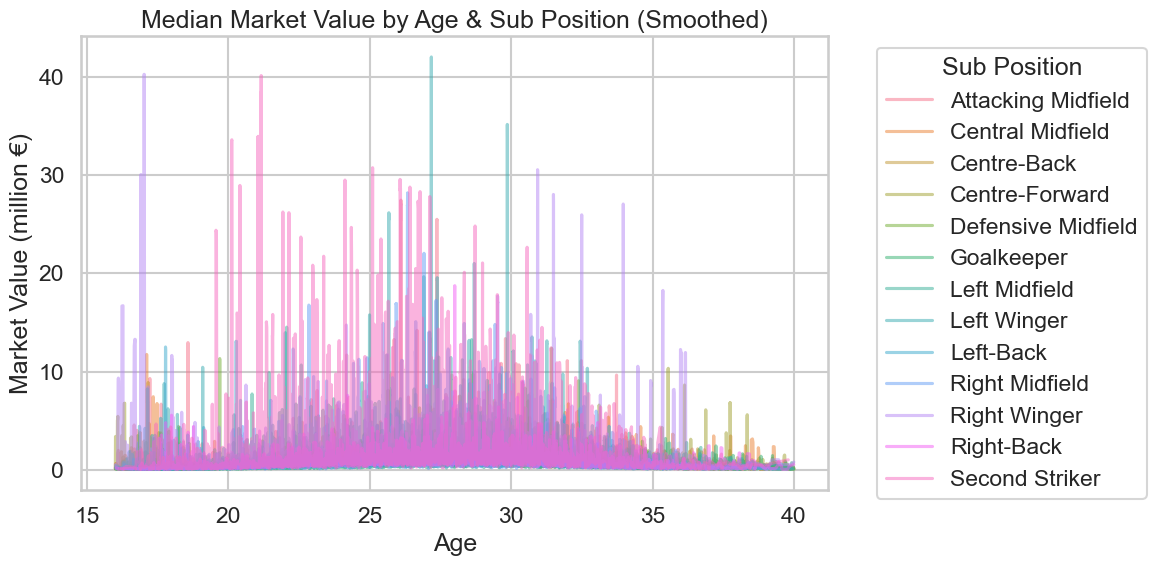

In [14]:
plt.figure()
sns.lineplot(data=valuation_curve, x="age", y="expected_value_million", hue="sub_position", alpha=0.5)
plt.title("Median Market Value by Age & Sub Position (Smoothed)")
plt.ylabel("Market Value (million €)")
plt.xlabel("Age")
plt.legend(title="Sub Position", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


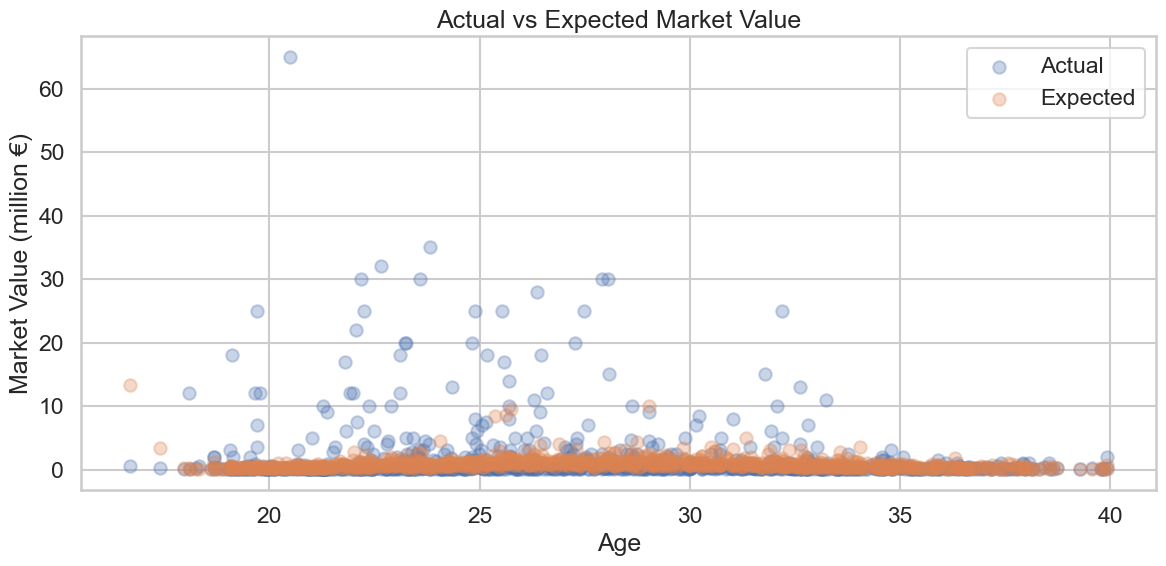

In [15]:

sample = latest_values.sample(1000, random_state=42) if len(latest_values) > 1000 else latest_values
plt.figure()
plt.scatter(sample["age"], sample["value_million"], alpha=0.3, label="Actual")
plt.scatter(sample["age"], sample["expected_value_million"], alpha=0.3, label="Expected")
plt.title("Actual vs Expected Market Value")
plt.xlabel("Age")
plt.ylabel("Market Value (million €)")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Persist Development Outputs

In [16]:

output_cols = [
    "player_id",
    "age",
    "sub_position",
    "value_million",
    "expected_value_million",
    "valuation_above_curve",
    "ga_per_90",
    "expected_ga_per_90",
    "performance_above_curve",
    "minutes_per_90",
    "expected_minutes_per_90",
    "minutes_above_curve",
    "aging_score",
    "development_tier",
]

development_outputs = latest_values[output_cols].copy()
output_path = PROCESSED_DIR / "development_outputs.parquet"
development_outputs.to_parquet(output_path, index=False)
print(f"Saved development dataset to {output_path}")


Saved development dataset to ../data/processed/development_outputs.parquet


## 8. Refreshing with New Data
To rerun with new CSVs, point `DATA_DIR` to the folder containing them and rerun all cells. Each helper function is parameterized by `data_dir`, so outputs regenerate without additional code changes.